書籍「つくりながら学ぶ！ 生成AIアプリ & エージェント開発入門」の第9章を作ってみる
===================



**1. 概要**：

書籍：「つくりながら学ぶ！ 生成AIアプリ & エージェント開発入門」(発売日 2024/7/18) [[link](https://www.amazon.co.jp/dp/4839985022)]

著者：ML_Bear（本名: 内田 直孝）さん


の「第9章：インターネットで調べ物をしてくれるエージェントを作ろう」

を、Google Colaboratory & LangGraphで動作するように、自分でも作りながら、学んでみる



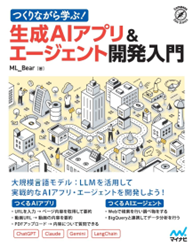


<br>

**2. 実装者**：小川雄太郎

**3. 実装日**：2024年08月03日

**4. 実行環境**：Google Colabratory、CPU

**5. 参考記事・スライド類**


書籍：「つくりながら学ぶ！ 生成AIアプリ & エージェント開発入門 (2024/7/18)」[[link](https://www.amazon.co.jp/dp/4839985022)]


ブログ: 「つくりながら学ぶ！生成AIアプリ＆エージェント開発入門」を出版しました [[link](https://zenn.dev/ml_bear/articles/0c4272c9dcaba3)]


**6. 実装のメイン参考**

https://github.com/naotaka1128/llm_app_codes/tree/main



**7. その他参考にした記事**

- 生成AIエージェントのワークフローの実装方法と関連ライブラリについて理解する [[link]](https://aitc.dentsusoken.com/column/How_to_implement_workflows_for_generative_AI_agents)


- 従来の LangChainエージェント から LangGraphエージェント への移行手順 [[link](https://note.com/npaka/n/nf9bb361de223)]

---

# [0] 初期設定とハイパラ設定


## [0-1] Pythonのバージョン確認

In [ ]:
import sys

print("Pythonのバージョン：", sys.version)


Pythonのバージョン： 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


## [0-2] installの実施

書籍のインストール案内にバージョンを合わせようとしたのですが、

```from langchain.agents import AgentExecutor, create_tool_calling_agent```

にて、errorが出たのでひとまず最新版をインストールしてみます

In [ ]:
# OpenAI系のライブラリとトークンカウント用
!pip -q install openai  # ==1.29.0
!pip -q install tiktoken  # ==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.1/337.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00


In [ ]:
# LangChain周り
!pip -q  install langchain  # ==0.1.6
!pip -q  install langchain-community  # ==0.0.34
# !pip -q  install langchain-core  # ==0.1.46
!pip -q  install langchain-openai  # ==0.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00


メインであるlangchainは、どのバージョンが入ったのか確認しておきます

In [ ]:
import langchain

print(langchain.__version__)


0.2.12


# [1] DuckDuckGoでWeb検索をする部分（ツール）を作る

## [1-0] 依存ライブラリのインストール

In [ ]:
!pip -q install duckduckgo-search==4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.4 MB/s eta 0:00:00


## [1-1] search_ddg.py のDuckDuckGoの検索Toolを定義・実装する

In [ ]:
# 【参考】
# GitHub: https://github.com/naotaka1128/llm_app_codes/chapter_009/tools/search_ddg.py

# import部分
from itertools import islice
from duckduckgo_search import DDGS
from langchain_core.tools import tool
from langchain_core.pydantic_v1 import (BaseModel, Field)


In [ ]:
class SearchDDGInput(BaseModel):
    """正しく文字列で検索クエリが入ってくるようにする（Validator的な）
    　　≒文字列でない検索入力のデータ型をはじく"""

    query: str = Field(description="検索したいキーワードを入力してください")

せっかくなのでTool関数の説明文章は自分なりに変更して作成してみます

（この関数の説明が、LLM-AgentがどのToolを使用するのかを判断する拠り所になるので重要です）

In [ ]:
@tool(args_schema=SearchDDGInput)
def search_ddg(query, max_result_num=5):
    """
    ## Toolの説明
    本ToolはDuckDuckGoを利用し、Web検索を実行するためのツールです。

    ## Toolの動作方法
    1. userが検索したいキーワードに従ってWeb検索します
    2. assistantは以下の戻り値の形式で検索結果をuserに回答します

    ## 戻り値の形式

    Returns
    -------
    List[Dict[str, str]]:
    - title
    - snippet
    - url
    """

    # [1] Web検索を実施
    res = DDGS().text(query, region='jp-jp', safesearch='off', backend="lite")
    # region = 'wt-wt'は位置の指定なし、日本の場合はjp-jp

    # [2] 結果のリストを分解して戻す
    return [
        {
            "title": r.get('title', ""),
            "snippet": r.get('body', ""),
            "url": r.get('href', "")
        }
        for r in islice(res, max_result_num)
    ]

## [1-2] DuckDuckGoだけで人力で動かして検索して動作させてみる


まずは人力で検証しておきます

In [ ]:
# [1] 検索文章
query_ddg = "2024年全豪オープンテニスの男子シングルスって誰が優勝した？"

# [2] DuckDuckGoを人力で動かして？、検索
res = DDGS().text(query_ddg, region='jp-jp', safesearch='off', backend="lite")


In [ ]:
# [3] 検索結果を一つずつ取得して表示
for result in res:
    print(result)

{'title': '【全豪OP】男子シングルスはシナーが逆転勝ち 4大大会初制覇― スポニチ Sponichi Annex スポーツ', 'href': 'https://www.sponichi.co.jp/sports/news/2024/01/29/kiji/20240129s00028000133000c.html', 'body': 'テニス・全豪オープン最終日 （ 2024年1月28日 メルボルン・パーク ） 男子シングルスで優勝したヤニク・シナー（左）と準優勝のダニル ...'}
{'title': 'テニス全豪op 男子シングルス ヤニック・シンネルが優勝 | Nhk', 'href': 'https://www3.nhk.or.jp/news/html/20240128/k10014338701000.html', 'body': 'テニスの全豪オープンは28日、男子シングルスの決勝が行われイタリアの22歳、ヤニック・シンネル選手がロシア出身のダニール・メドベージェフ ...'}
{'title': '男子はヤニック･シナー、女子はアリナ･サバレンカが優勝──テニス全豪オープン2024 - トピックス | 日豪プレス - オーストラリアの生活 ...', 'href': 'https://nichigopress.jp/topics-item/98720/', 'body': '男子はヤニック･シナー、女子はアリナ･サバレンカが優勝──テニス全豪オープン2024. 2024.01.29. 女子シングルスを制したアリナ･サバレンカ. （文･写真＝板屋雅博）. 2024年グランドスラムの第1戦、全豪オープン2024は、1月28日に15日間の日程を終えた ...'}
{'title': 'テニス全豪オープン2024丨結果速報・日本人選手・成績一覧', 'href': 'https://olympics.com/ja/news/tennis-all-australian-open-2024-results', 'body': 'テニス全豪オープン2024丨結果速報・日本人選手・成績一覧. 大坂なおみの復帰などで話題となった全豪オープン2024。. ここでは優勝者、日本人選手の成績を掲載する。. 1 分 執筆者 オリンピックチャンネル編集部 2024年 1

Webページの「title」、「href」、「bodyの冒頭」が取得できているようです

この検索を人がタイミングを決めて実行するのではなく、LLM-Agentによしなに勝手に実行してもらいたいです

# [2] 検索結果のページを閲覧して内容（本文）を取得する部分（ツール）を作る

## [2-0] 依存ライブラリのインストール

In [ ]:
!pip -q  install duckduckgo-search==4.2
# !pip -q  install langchain_text_splitters  # ==0.0.1

# 以下はWebサイトから本文を抜き出すために使用
!pip -q  install html2text==2020.1.16
!pip -q  install readability-lxml==0.8.1
!pip -q  install lxml[html_clean]==5.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.8 MB/s eta 0:00:00


書籍ではlangchain_text_splitters を使用し、長い文書をチャンク（小さな文章）に分割してきちんと処理する手法が解説されています。

今回は簡易版として、本文の冒頭からガバっと取得することにします

## [2-1] fetch_page.py の webページ本文取得とtext splittingのToolを定義・実装する

In [ ]:
# 【参考】
# GitHub: https://github.com/naotaka1128/llm_app_codes/chapter_009/tools/fetch_page.py

# import部分
import requests
import html2text
from readability import Document
from langchain_core.tools import tool
from langchain_core.pydantic_v1 import (BaseModel, Field)
# from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
class FetchPageInput(BaseModel):
    """正しく文字列や数字で入ってくるようにする（Validator的な）
    """
    url: str = Field()
    # page_num: int = Field(0, ge=0)  # こちらは簡易的に進めたいので、使用しないことにします


せっかくなのでこちらのTool関数の説明文章も自分なりに変更して作成してみます


In [ ]:
@tool(args_schema=FetchPageInput)
def fetch_page(url, page_num=0, timeout_sec=10):
    """
    ## Toolの説明
    本Toolは指定されたURLのWebページから本文の文章を取得するツールです。
    詳細な情報を取得するのに役立ちます

    ## Toolの動作方法
    1. userがWebページのURLを入力します
    2. assistantはHTTPレスポンスステータスコードと本文の文章内容をusrに回答します

    ## 戻り値の設定
    Returns
    -------
    Dict[str, Any]:
    - status: str
    - page_content
      - title: str
      - content: str
      - has_next: bool
    """

    # [1] requestモジュールで指定URLのＷebページ全体を取得
    try:
        response = requests.get(url, timeout=timeout_sec)
        response.encoding = 'utf-8'
    except requests.exceptions.Timeout:
        return {
            "status": 500,
            "page_content": {'error_message': 'Could not download page due to Timeout Error. Please try to fetch other pages.'}
        }

    # [2] HTTPレスポンスステータスコードが200番でないときにはエラーを返す
    if response.status_code != 200:
        return {
            "status": response.status_code,
            "page_content": {'error_message': 'Could not download page. Please try to fetch other pages.'}
        }

    # [3] 本文取得の処理へ（書籍ではtry-exceptできちんとしていますが、簡易に）
    doc = Document(response.text)
    title = doc.title()
    html_content = doc.summary()
    content = html2text.html2text(html_content)

    # [4] 本文の冒頭を取得
    chunk_size = 1000*3  #【chunk_sizeを大きくしておきます】
    content = content[:chunk_size]

    # [5] return処理 ※最初のchunkだけを返すことに簡易化します
    return {
        "status": 200,
        "page_content": {
            "title": title,
            "content": content,  # chunks[page_num], を文書分割をやめて、contentにします
            "has_next": False  # page_num < len(chunks) - 1
        }
    }

## [2-2] 人力でURLから本文を取得してみる

いきなりLLM-Agentで試すのではなく、人力で確認するのは大切です（と私は考えています）

[1] のDuckDuckGoで検索ヒットした1つ目と2つ目のURLで試してみましょう

In [ ]:
# URLを指定
url_hit = "https://www.sponichi.co.jp/sports/news/2024/01/29/kiji/20240129s00028000133000c.html"

# 実行
fetch_page(url_hit)

{'status': 200,
 'page_content': {'title': '【全豪OP】男子シングルスはシナーが逆転勝ち 4大大会初制覇― スポニチ Sponichi Annex スポーツ',
  'content': 'バスケ女子日本代表が五輪最終予選へ出発 メンバーも事前合宿地も非公表 恩塚監督「情報戦なので」\n\n［ 2024年1月29日 19:53 ］ バスケット\n\n',
  'has_next': False}}

In [ ]:
# URLを指定
url_hit = "https://www3.nhk.or.jp/news/html/20240128/k10014338701000.html"

# 実行
fetch_page(url_hit)

{'status': 200,
 'page_content': {'title': 'テニス全豪OP 男子シングルス ヤニック・シンネルが四大大会初優勝 ダニール・メドベージェフに逆転勝ち | NHK | テニス',
  'content': '試合は世界ランキング3位のメドベージェフ選手に2セットをリードされる展開になりましたが、世界4位のシンネル選手は第3セット、5-4とリードして迎えた第10ゲームで相手のサービスゲームのブレークに成功して1セットを奪い返すと、続く第4セットも6-4で取って追いつきました。\n\n',
  'has_next': False}}

1つ目はページ内の、メインの本文とは関係ない部分を取得してしまっています。

2つ目は本文をうまく取得できているようです。

# [3] Agent本体の実装へ（LangChain Agentを使用版）

LLM-Agentが使用するツールを用意できたので、以下のように、よしなに動いて欲しいです

1. ToolのsearchでURLを取得
2. fetch_pageで本文を取得
3. userの質問の回答が生成できなければ、1. or 2.へ戻る
4. 最後にuserの質問に対する回答を生成する

という流れをLLM-Agentで実現したいです

## [3-1] AgentのSystem Promptの作成

せっかくなのでSystem Promptも自分なりに変更して作成してみます

In [ ]:
CUSTOM_SYSTEM_PROMPT = """
## あなたの役割
あなたの役割はuserの入力する質問に対して、インターネットでWebページを調査をし、回答することです。

## あなたが従わなければいけないルール
1. 回答はできるだけ短く、要約して回答してください
2. 文章が長くなる場合は改行して見やすくしてください
3. 回答の最後に改行した後、参照したページのURLを記載してください

"""

## [3-2] Agentの定義

In [ ]:
# 【参考】
# GitHub: https://github.com/naotaka1128/llm_app_codes/chapter_009/main.py

# import部分
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.memory import ConversationBufferWindowMemory
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
# from langchain_community.callbacks import StreamlitCallbackHandler
# 書籍ではStreamlitで綺麗にUIを作成していますが、今回は簡易的にいきます

# models
from langchain_openai import ChatOpenAI

In [ ]:
def create_agent():
    # [1]、[2]で定義したAgentが使用可能なToolを指定します
    tools = [search_ddg, fetch_page]

    # プロンプトを与えます。ChatPromptTemplateの詳細は書籍本体の解説をご覧ください。
    # 重要な点は、最初のrole "system"に上記で定義したCUSTOM_SYSTEM_PROMPTを与え、
    # userの入力は{input}として動的に埋め込むようにしている点です
    # agent_scratchpadはAgentの動作の途中経過を格納するためのものです
    prompt = ChatPromptTemplate.from_messages([
        ("system", CUSTOM_SYSTEM_PROMPT),
        # MessagesPlaceholder(variable_name="chat_history"),  # チャットの過去履歴はなしにしておきます
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])

    # 使用するLLMをOpenAIのGPT-4o-miniにします（GPT-4だとfechなしに動作が完了してしまう）
    llm = ChatOpenAI(temperature=0., model_name="gpt-4o-mini")

    # Agentを作成
    agent = create_tool_calling_agent(llm, tools, prompt)

    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True,  # これでAgentが途中でToolを使用する様子が可視化されます
        # memory=st.session_state['memory']  # memory≒会話履歴はなしにしておきます
    )


以上でAgentEecutorを戻す関数が定義できました

## [3-4] OPENAI_API_KEYを環境変数に与える

Google Colaboratoryを使用する場合、API_Keyのような機密情報は、画面左タブの「鍵マーク」、シークレットで管理するのが安全です

今は簡易的に直書きしています

**APIキーを直書きして、Gitにpushしないように気をつけてください！**

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-hogehogehogehogehoge"

## [3-3] Agentを動作させる

In [ ]:
# [1] Agentを作成
web_browsing_agent = create_agent()

# [2] 質問文章
query_ddg = "2024年全豪オープンテニスの男子シングルスって誰が優勝した？各セットのポイントも教えてください"

# [3] エージェントを実行
response = web_browsing_agent.invoke(
    {'input': query_ddg},  # userの入力に上記の質問を入れる
)



> Entering new AgentExecutor chain...

Invoking: `search_ddg` with `{'query': '2024年全豪オープンテニス 男子シングルス 優勝者 各セットのポイント'}`


[{'title': '【全豪OP】男子シングルスはシナーが逆転勝ち 4大大会初制覇― スポニチ Sponichi Annex スポーツ', 'snippet': 'テニス・全豪オープン最終日 （ 2024年1月28日 メルボルン・パーク ） 男子シングルスで優勝したヤニク・シナー（左）と準優勝のダニル ...', 'url': 'https://www.sponichi.co.jp/sports/news/2024/01/29/kiji/20240129s00028000133000c.html'}, {'title': 'テニス全豪オープン2024丨結果速報・日本人選手・成績一覧', 'snippet': 'テニス全豪オープン2024丨結果速報・日本人選手・成績一覧. 大坂なおみの復帰などで話題となった全豪オープン2024。. ここでは優勝者、日本人選手の成績を掲載する。. 1 分 執筆者 オリンピックチャンネル編集部 2024年 1月 10日 22:15 GMT-8. テニス. (Getty Images) 1 ...', 'url': 'https://olympics.com/ja/news/tennis-all-australian-open-2024-results'}, {'title': '【2024年】全豪オープンテニスの結果（グランドスラム） - テニスk', 'snippet': '2024年1月14日から1月28日（2024年第3、4週）にオーストラリアのメルボルンで開催されるグランドスラム「全豪オープン」の男子シングルスと女子シングルスの1回戦から決勝までの結果、放送予定を見ていきます。. 日本勢では男子は西岡良仁、ダニエル太郎 ...', 'url': 'https://tenniskei.com/2024-grand-slam-australian-open-result'}, {'title': '【2024年】全豪オープンテニス決勝の結果、日程・時間、中継・放送予定｜男子/女子 シングルス

In [ ]:
# 質問と回答を表示
# ==================
print("（質問）", response["input"])
print("====")
print("（Agentの回答）", response["output"])



（質問） 2024年全豪オープンテニスの男子シングルスって誰が優勝した？各セットのポイントも教えてください
====
（Agentの回答） 2024年全豪オープンテニスの男子シングルスでは、ヤニック・シナーが優勝しました。決勝戦ではダニール・メドベージェフを相手に、セットカウント3-2で勝利しました。

各セットのポイントは以下の通りです：

- 第1セット: シナー 3 - 6 メドベージェフ
- 第2セット: シナー 3 - 6 メドベージェフ
- 第3セット: シナー 6 - 4 メドベージェフ
- 第4セット: シナー 6 - 4 メドベージェフ
- 第5セット: シナー 6 - 3 メドベージェフ

試合時間は3時間44分でした。

参照したページのURL:  
https://tenniskei.com/2024-grand-slam-australian-open-result


# [4] Agent本体の実装へ（LangGraphエージェントのReactAgentExecutorを使用版）

## [4-0] 依存ライブラリのインストール

In [ ]:
!pip -q install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
# versionの確認
import langgraph

print(langgraph.__version__)

0.1.19


## [4-1] Agent（Prebuiltのreact_agent≒ReactAgentExecutorを使用）を定義

システムプロンプトなどは、[3] のLangChainのAgentExecutorのときと同じものを使用します

Agentの統制方法はLangGraphの場合は3種類ほどありますが、AgentExecutorのときと同様に、「ChatPromptTemplate」を使用するバージョンで進めます

参考：https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_core.messages import AnyMessage


# プロンプトを定義
prompt = ChatPromptTemplate.from_messages([
    ("system", CUSTOM_SYSTEM_PROMPT),  # [3] で定義したのと同じシステムプロンプトです
    ("user", "{messages}")
    # MessagesPlaceholder(variable_name="agent_scratchpad")  # agent_scratchpadは中間生成物の格納用でしたが、LangGraphでは不要です
])


# LangGraphではGraph構造で全体を処理するので、stateを変化させノードが移るタイミングで、promptを（会話やAgentの自分メモ）を進めるように定義します
def _modify_messages(messages: list[AnyMessage]):
    return prompt.invoke({"messages": messages}).to_messages()

# ReactAgentExecutorの準備
# modelとtoolsは[3]と同じものを使用します
tools = [search_ddg, fetch_page]
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
# 【2024年8月2日現在では、modelにgpt-4o-miniを使用すると日本語ではうまく動作してくれません】そのため、gpt-4oを使用

web_browsing_agent = create_react_agent(llm, tools, state_modifier=_modify_messages)
# 変数名はgraphや、appを使用しているケースもあります



## [4-2] LangGraphでAgentを動作させる

In [ ]:
# [1] 質問文章
# query_ddg = "Who won the 2024 Australian Open Tennis Men's Singles? And what are the points for each set?"
query_ddg = "2024年全豪オープンテニスの男子シングルスって誰が優勝した？各セットのポイントも教えてください"

# [2]ステップの段階的出力（一度でinvokeする流れはこの後で実行します。veboseがなく、動作が分かりにくいので）
for step in web_browsing_agent.stream({"messages": [("user", query_ddg)]}, stream_mode="updates"):
    print(step)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tZ1BuIAdUT3m02CIn80WC00p', 'function': {'arguments': '{"query":"2024 Australian Open men\'s singles winner and set scores"}', 'name': 'search_ddg'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 503, 'total_tokens': 527}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3cd8b62c3b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d03c029-9760-4337-b12d-22ac764db07b-0', tool_calls=[{'name': 'search_ddg', 'args': {'query': "2024 Australian Open men's singles winner and set scores"}, 'id': 'call_tZ1BuIAdUT3m02CIn80WC00p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 503, 'output_tokens': 24, 'total_tokens': 527})]}}
{'tools': {'messages': [ToolMessage(content='[{"title": "Australian Open 2024: Jannik Sinner, Aryna Sabalenka ... | CBS Sports", "snippet": "Jannik Sinner came back from two sets down to beat Daniil 

agentノードでどのようなmessagesが使用され、どのような結果が返ってきたか、

そのあとは、toolsノードへ行き、どのツールをどんな変数内容で使用したのか、グラフの各エッジでの動作が読み取れます

In [ ]:
# [3] エージェントをinvokeで実行（invokeのあとの変数の入れ方が少し異なります）
messages = web_browsing_agent.invoke({"messages": [("user", query_ddg)]})
# 変数名はresponseではなく、messagesが使用されます


# [4] 質問と回答を表示
# ==================
print("（質問）", response["input"])
print("====")
print("（Agentの回答）", response["output"])

（質問） 2024年全豪オープンテニスの男子シングルスって誰が優勝した？各セットのポイントも教えてください
====
（Agentの回答） 2024年全豪オープンテニスの男子シングルスでは、ヤニック・シナーが優勝しました。決勝戦ではダニール・メドベージェフを相手に、セットカウント3-2で勝利しました。

各セットのポイントは以下の通りです：

- 第1セット: シナー 3 - 6 メドベージェフ
- 第2セット: シナー 3 - 6 メドベージェフ
- 第3セット: シナー 6 - 4 メドベージェフ
- 第4セット: シナー 6 - 4 メドベージェフ
- 第5セット: シナー 6 - 3 メドベージェフ

試合時間は3時間44分でした。

参照したページのURL:  
https://tenniskei.com/2024-grand-slam-australian-open-result


## [4-3] LangGraph Agentのグラフ構造を可視化する

せっかくLangGraphで構築しているので、グラフ構造、各ノードを確認すべく、グラフを可視化します

create_react_agent関数の戻り値はLangGraphの型であるCompiledGraphなので、すぐにグラフ描画できます

In [ ]:
# 描画に必要なモジュールをインストール
!apt-get install -qq graphviz libgraphviz-dev pkg-config
!pip install -q pygraphviz

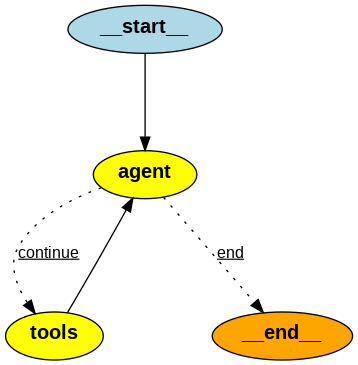

In [ ]:
# 参考：https://github.com/langchain-ai/langgraph/blob/main/examples/persistence.ipynb

from IPython.display import Image, display

# 描画
display(Image(web_browsing_agent.get_graph().draw_png()))  # draw_pngはdraw_mermaid_pngもOKです


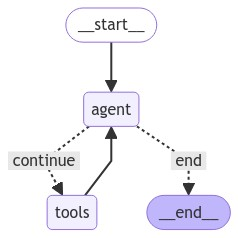

In [ ]:
# 参考：https://github.com/langchain-ai/langgraph/blob/main/examples/persistence.ipynb

from IPython.display import Image, display

# 描画
display(Image(web_browsing_agent.get_graph().draw_mermaid_png()))  # draw_pngはdraw_mermaid_pngもOKです


Agentがtoolsを使用し続けて、終了条件（end, has_next": false）を満たせば、end ノードに移るという構造が描画されました

Agentにやってもらうことがシンプルなので仕方ないのですが、ちょっと簡素ですね。

<br>

複数Agentや独自のグラフ構造を作成するなどした場合にはこの可視化機能は役立つと思います

# [5] まとめ

以上、

書籍：「つくりながら学ぶ！ 生成AIアプリ & エージェント開発入門」(発売日 2024/7/18) [[link](https://www.amazon.co.jp/dp/4839985022)]

著者：ML_Bear（本名: 内田 直孝）さん


の「第9章：インターネットで調べ物をしてくれるエージェントを作ろう」を参考に、自分なりに作ってみて学習しました。

本書は

- 最新の知識をしっかりと解説してくれている
- 私も本格的にLLM系の実装に触れていないので、学びがとても多かった
- LLMアプリなどを作る土台となる知識がしっかりと身につく
- 本ノートブックでは割愛しましたが、StreamlitでカッコよいUIも作れる
- 作ってみるアプリやLLM-Agentが簡単過ぎず、難しすぎない
- 前から順番にやっていくことでどんどん理解が深まる

という特徴があり、非常に学びになりました。

LLM系に非常に慣れた方には少し物足りないかもしれません（タイトルの通り、入門書なので）

ですが、「これからAI・LLM系の何か実装をやってみたいな」と思っている方には非常におすすめな書籍だと感じました

2024年8月3日 小川雄太郎


# 以上